<a href="https://colab.research.google.com/github/ehsanh123/machine-learning/blob/main/trial_data_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import io
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#####################################################################################################################
#Loading data from mat file
#####################################################################################################################
mat_data = io.loadmat('/content/drive/MyDrive/mechine learning/PROACT_data_updated.mat')

#Extracting relevant variables from the loaded dictionary
data=mat_data['data']
data=np.delete(data,18,axis=1)

target=mat_data['survived']
Dt=mat_data['Dt']
labels=mat_data['labels'][0]
labels=np.delete(labels,18)
pat_id=mat_data['Pat_ID']

#####################################################################################################################
## Hard coding a train/test split across patient without any randomization
# It could randomized by making a random train/test split on pat_id
# And then using the corresponding indexes to extract corresponding visit records
#####################################################################################################################
Xtrain=data[0:11326,:]
Xtest=data[11326:,:]
# Target values for each time slot of 3 months:
# 0  survived
# 1  tracheotomy/death
# -1 not known (patient dropped out of follow up)
target_train=target[0:11326,:]
target_test=target[11326:,:]

# Naive way of train/test splitting, assuming visit independence
# Xtrain, Xtest, target_train, target_test = train_test_split(data, target[:,3], test_size=0.3)

Out of bag accuracy is: 0.7521
Train accuracy is: 1.0000
Test accuracy is: 0.6928


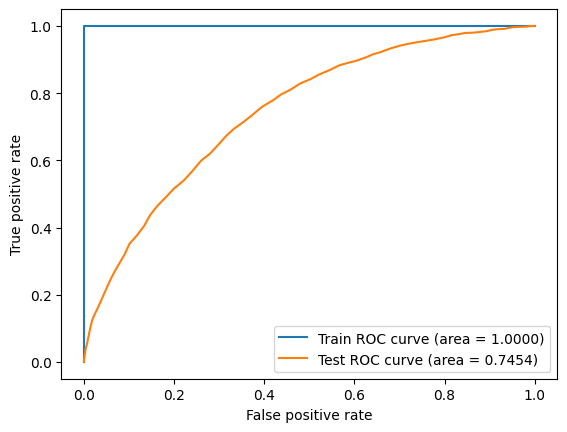

In [7]:
#####################################################################################################################
# Estimating survival in the 4th trimester
#####################################################################################################################

Ytrain=target_train[:,3]
Ytest=target_test[:,3]


RF= RandomForestClassifier(random_state=42, oob_score=True, n_estimators=100)


RF.fit(Xtrain[Ytrain>-1,:],Ytrain[Ytrain>-1])
Pest=RF.predict_proba(Xtrain)
pred_train=Pest[:,1]

# Predicting classification
Yest=RF.predict(Xtest)
# Predicting the probability of belonging to class 0 and class 1
Pest=RF.predict_proba(Xtest)

pred_test=Pest[:,1]
oob_accuracy= RF.oob_score_
train_accuracy=RF.score(Xtrain[Ytrain>-1,:],Ytrain[Ytrain>-1])
test_accuracy=RF.score(Xtest[Ytest>-1,:], Ytest[Ytest>-1])

print('Out of bag accuracy is: {:.4f}'.format(oob_accuracy))
print('Train accuracy is: {:.4f}'.format(train_accuracy))
print('Test accuracy is: {:.4f}'.format(test_accuracy))

fpr_t, tpr_t, th_t = metrics.roc_curve(Ytrain[Ytrain>-1], pred_train[Ytrain>-1])
train_auc = metrics.auc(fpr_t, tpr_t)

fpr, tpr, th = metrics.roc_curve(Ytest[Ytest>-1], pred_test[Ytest>-1])
test_auc = metrics.auc(fpr, tpr)

plt.plot(fpr_t,tpr_t, label='Train ROC curve (area = {:.4f})'.format(train_auc))
plt.plot(fpr,tpr, label='Test ROC curve (area = {:.4f})'.format(test_auc))

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

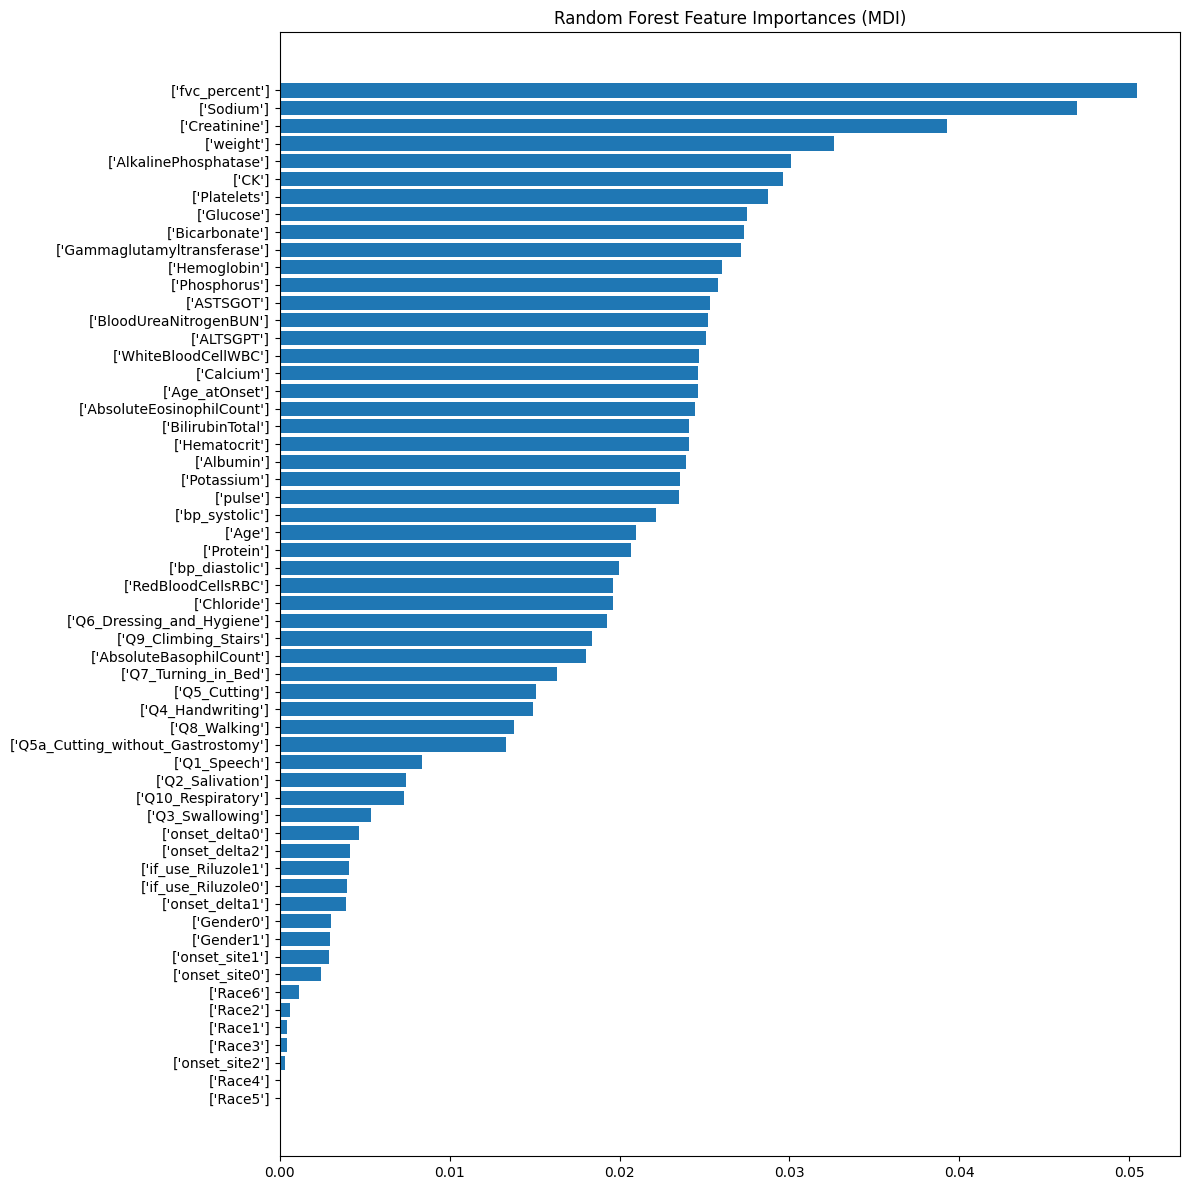

In [8]:
#####################################################################################################################
# Feature importance
#####################################################################################################################

tree_feature_importances = RF.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, 58)
fig=plt.figure(figsize=(12,12))
ax = fig.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(labels[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

Train accuracy is: 0.6838
Test accuracy is: 0.6679


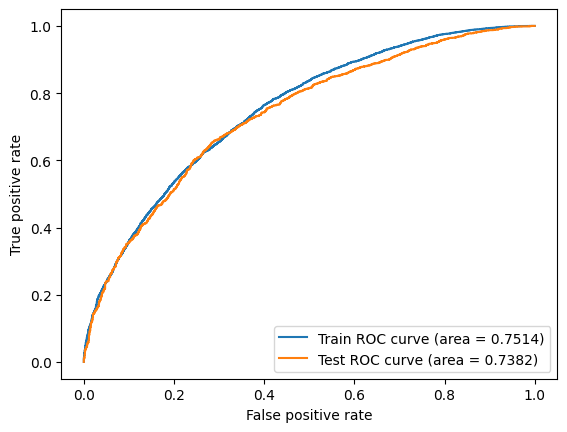

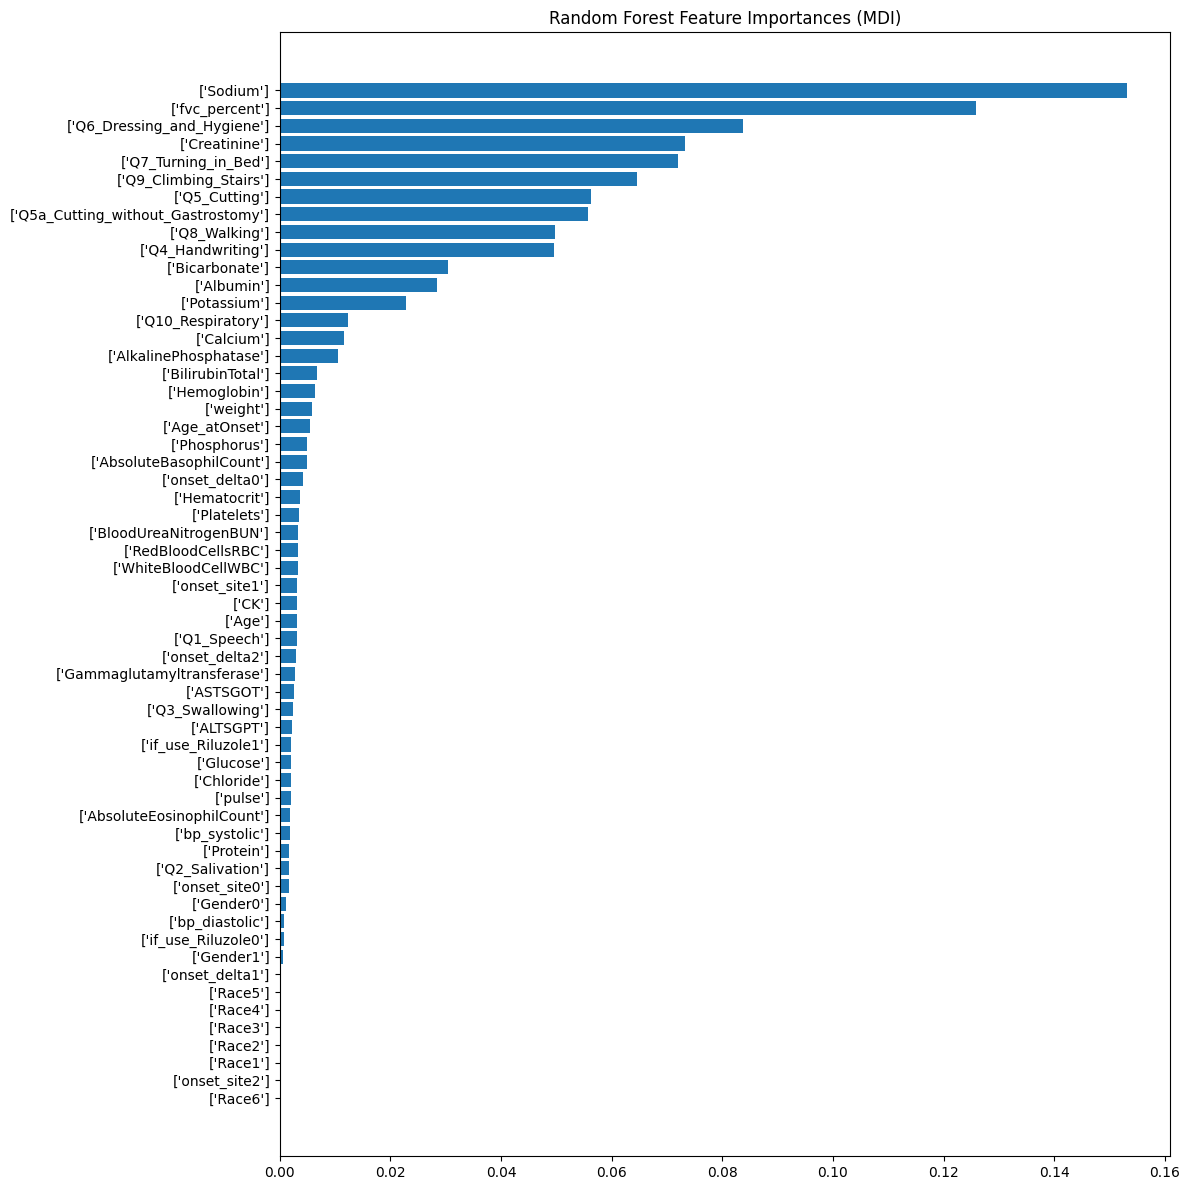

In [99]:
#####################################################################################################################
# Regularizing the decision trees
#####################################################################################################################
RF= RandomForestClassifier(random_state=42, oob_score=True, n_estimators=100,min_samples_leaf=100, max_depth=5)

def train_2(model,Xtrain,Ytrain,Xtest,Ytest,ver = 2):
  model.fit(Xtrain[Ytrain>-1,:],Ytrain[Ytrain>-1])
  Pest=model.predict_proba(Xtrain)
  pred_train=Pest[:,1]

  # Predicting classification
  Yest=model.predict(Xtest)
  # Predicting the probability of belonging to class 0 and class 1
  Pest=model.predict_proba(Xtest)

  pred_test=Pest[:,1]
  #oob_accuracy= model.oob_score_
  train_accuracy=model.score(Xtrain[Ytrain>-1,:],Ytrain[Ytrain>-1])
  test_accuracy=model.score(Xtest[Ytest>-1,:], Ytest[Ytest>-1])

  #print('Out of bag accuracy is: {:.4f}'.format(oob_accuracy))
  print('Train accuracy is: {:.4f}'.format(train_accuracy))
  print('Test accuracy is: {:.4f}'.format(test_accuracy))
  if ver < 2: return
  fpr_t, tpr_t, th_t = metrics.roc_curve(Ytrain[Ytrain>-1], pred_train[Ytrain>-1])
  train_auc = metrics.auc(fpr_t, tpr_t)

  fpr, tpr, th = metrics.roc_curve(Ytest[Ytest>-1], pred_test[Ytest>-1])
  test_auc = metrics.auc(fpr, tpr)

  plt.plot(fpr_t,tpr_t, label='Train ROC curve (area = {:.4f})'.format(train_auc))
  plt.plot(fpr,tpr, label='Test ROC curve (area = {:.4f})'.format(test_auc))

  plt.legend(loc='lower right')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  #plt.show()

  #####################################################################################################################
  # Feature importance
  #####################################################################################################################

  tree_feature_importances = RF.feature_importances_
  sorted_idx = tree_feature_importances.argsort()

  y_ticks = np.arange(0, 58)
  fig=plt.figure(figsize=(12,12))

  if ver < 3: return sorted_idx
  ax = fig.subplots()
  ax.barh(y_ticks, tree_feature_importances[sorted_idx])
  ax.set_yticks(y_ticks)
  ax.set_yticklabels(labels[sorted_idx])
  ax.set_title("Random Forest Feature Importances (MDI)")
  fig.tight_layout()
  plt.show()
  #print(labels[sorted_idx])
  return sorted_idx

b = train_2(RF,Xtrain,Ytrain,Xtest,Ytest,3)

#homework 1

Out of bag accuracy is: 0.6863
Train accuracy is: 0.7200
Test accuracy is: 0.6807


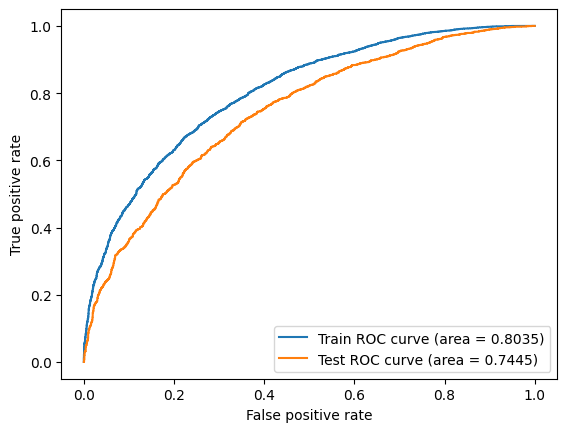

<Figure size 1200x1200 with 0 Axes>

In [82]:
model2 = RandomForestClassifier(
    random_state=42
    , oob_score=True,
    n_estimators=100,
    min_samples_leaf=50,
    max_depth=8)
a = train_2(model2,Xtrain,Ytrain,Xtest,Ytest)


Out of bag accuracy is: 0.6690
Train accuracy is: 0.6908
Test accuracy is: 0.6687


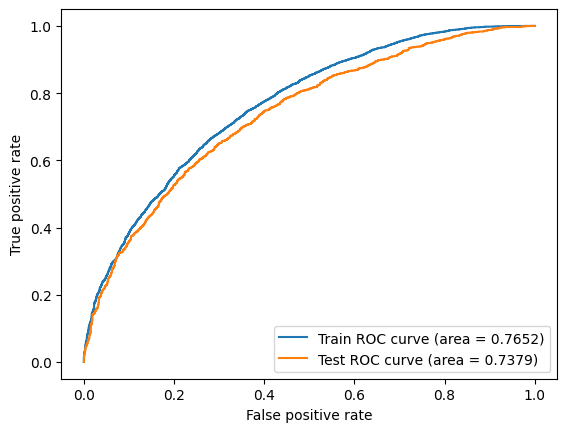

<Figure size 1200x1200 with 0 Axes>

In [83]:
model2 = RandomForestClassifier(
    random_state=42
    , oob_score=True,
    n_estimators=100,
    min_samples_leaf=10,
    max_depth=5)
a = train_2(model2,Xtrain,Ytrain,Xtest,Ytest)


#homework 2

In [77]:
a1 = a[:25]
X2 = Xtrain[:,a1]
X3 = Xtest[:,a1]

In [78]:
# import pandas as pd
# a_series = pd.Series(a)
# b= a_series

# last_25_labels = [item[0] for item in a[-25:]]  # Extract labels and get last 25

# Xtrain_df = pd.DataFrame(Xtrain, columns=[item[0] for item in a])  # Set column names using 'a'
# a2 = Xtrain_df.loc[:, last_25_labels]
# Xtest_df = pd.DataFrame(Xtest, columns=[item[0] for item in a])  # Set column names using 'a'
# a3 = Xtest_df.loc[:, last_25_labels]

# a2.head()

Out of bag accuracy is: 0.5802
Train accuracy is: 0.5967
Test accuracy is: 0.5873


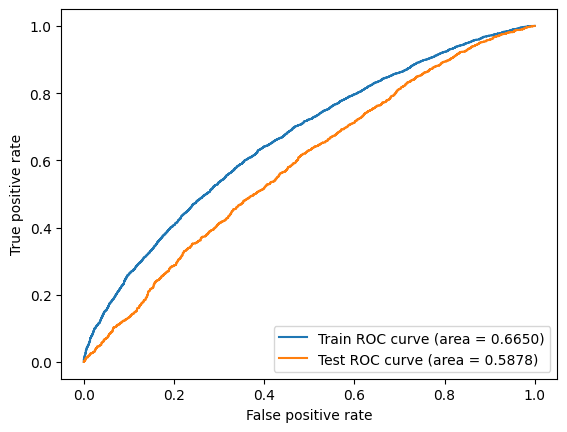

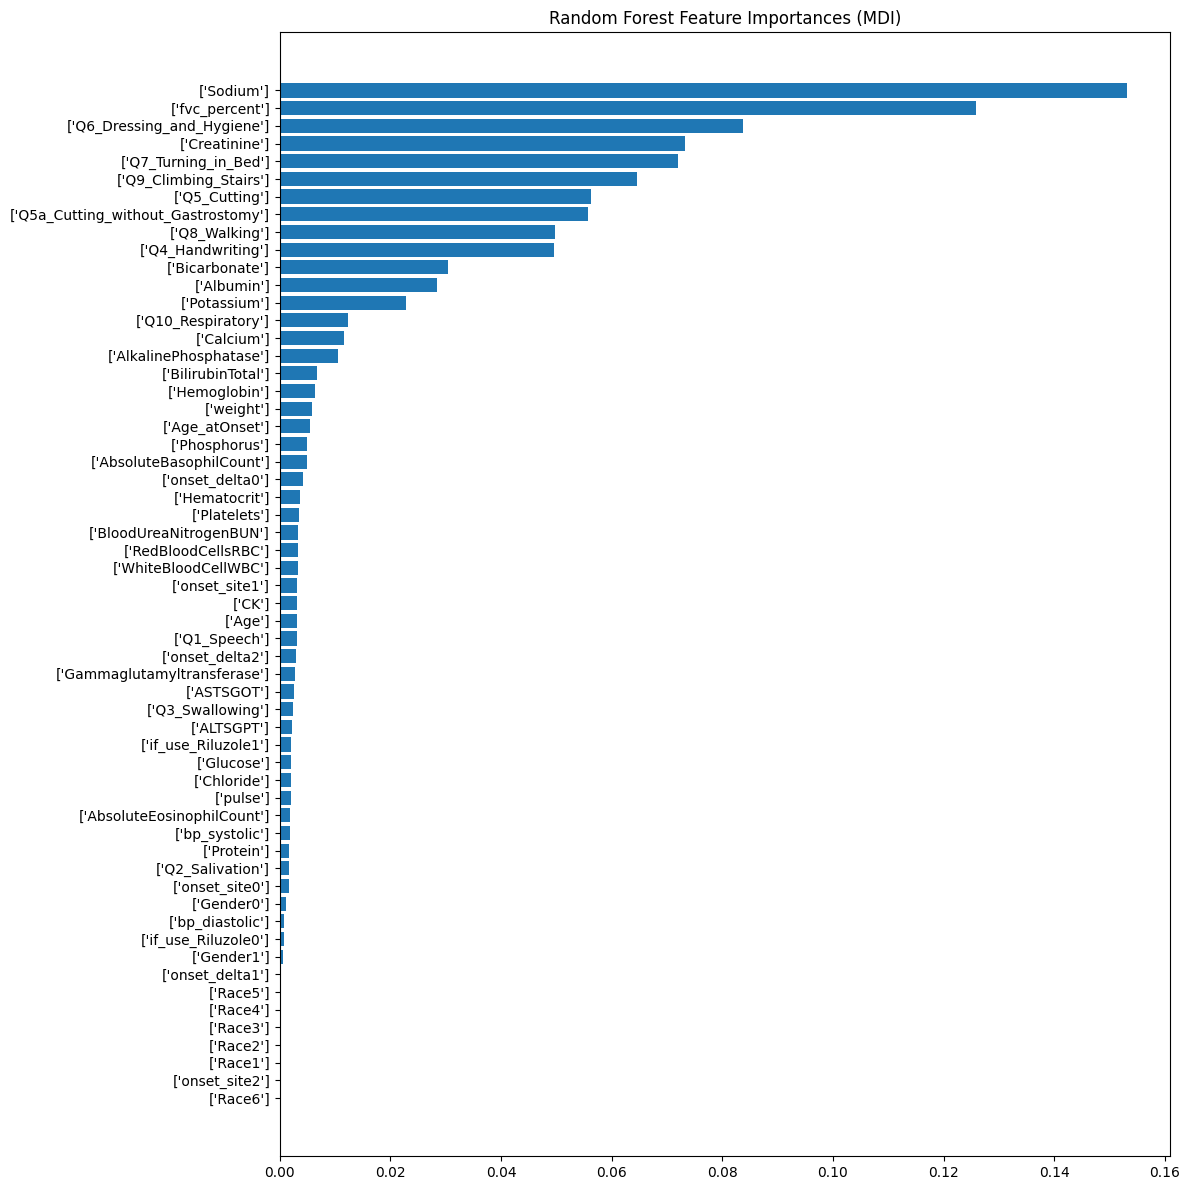

In [86]:
model2 = RandomForestClassifier(
    random_state=42
    , oob_score=True,
    n_estimators=100,
    min_samples_leaf=100,
    max_depth=8)
b = train_2(model2,X2,Ytrain,X3,Ytest,3)
#model2.fit(a2,



#homework3

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train accuracy is: 0.7126
Test accuracy is: 0.6938


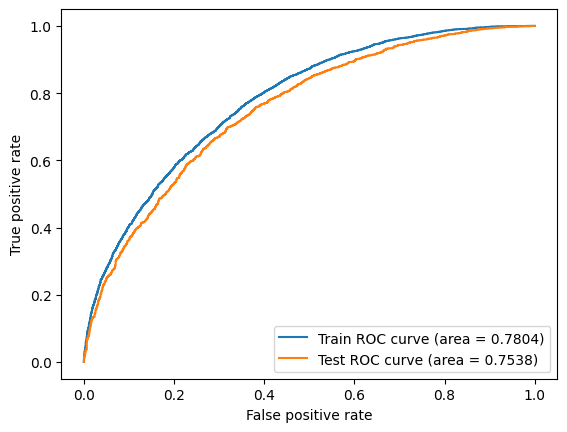

<Figure size 1200x1200 with 0 Axes>

In [102]:
from sklearn.ensemble import AdaBoostClassifier

# Define a Random Forest base learner
rf_base = RandomForestClassifier(
    n_estimators=10,  # Few estimators to avoid over-complexity
    max_depth=3,      # Restrict depth for a weak learner
    random_state=42
)

# Define the AdaBoost classifier with the Random Forest base learner
adaboost_with_rf = AdaBoostClassifier(
    estimator=rf_base,
    n_estimators=50,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    random_state=42
)

b = train_2(adaboost_with_rf,Xtrain,Ytrain,Xtest,Ytest)
